# ReadMe
Author: Matthew P. Burruss, March 2020

## Data Sets

### Classification
For information on the classification data set (description, how to load it, model weights, etc.), please see this [google drive folder](https://drive.google.com/drive/folders/1fEWVY_rb2J0tkNtQ-605dRCMfXRpRwMF?usp=sharing). 

### Regression (Note: This notebook focuses soley on the classification task)
For information on the regression data set, please see this [google drive folder](https://drive.google.com/drive/folders/1Ryvlt5HWsLiEVZkYpX_aTivrlDuCcWIt?usp=sharing). 

## Model Weights (Classification)
Pre-trained RBF and regular softmax Keras weights can be found in this [google drive folder](https://drive.google.com/drive/folders/1A1Nw6qhxb4DLISh9ei7EHRE4jdKOe1VK?usp=sharing)..

## Physical Attack
The code to perform the physical attack can be found in the utility function section below. The rest of the code loads the model and performs the attack as well as a few simple experiments.

## Getting Started (Classification)
The only thing that needs changing is in the RBF section under the "CHANGE ME" subsection. The correct path to the data set and the location of the model weights will need to be updated.

1. Navigate to this [google drive folder](https://drive.google.com/drive/folders/1fEWVY_rb2J0tkNtQ-605dRCMfXRpRwMF?usp=sharing) and create shortcuts in your own google drive for the data set (`deepnncar-classification-dataset.zip`) and any pre-trained weights you want to use.

2. In the "CHANGE ME" subsecton of the "RBF DAVEII: Classification with Rejection" section below you need to change the paths to point to your data set wherever that might be located in the google drive system.

5. Optional: Download the pre-trained weights for the DAVEII softmax classifier where the model can be loaded by invoking
```
softmax_model = DaveIIModel()
softmax_model.load(weights=os.path.join(MODEL_WEIGHT_LOC,'softmax_model.h5'))
```
where MODEL_WEIGHT_LOC is the path to the folder containing the weights in your google drive!



# Connect to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! pip3 install tensorflow==1.15.0

# RBF DAVEII: Classification with Rejection
The following code loads the partitioned DeepNNCar data set and performs the physical attack and re-creates a few of the experiments done in Matthew Burruss's Master's Thesis

## CHANGE ME

In [0]:
# Also update the location of the data set below if necessary
MODEL_WEIGHT_LOC ='/content/drive/My Drive/Colab Notebooks/DaveIIWeights' # Path to your weight shortcuts (should be a folder containing the rbf_model.h5 and softmax_model.h5 files)
PATH_TO_REGRESSION_CSV = '/content/drive/My Drive/DeepNNCar Dataset/deepnncar_regression.csv' # Path to the regression data set csv file shortcut if your interested in loading that
%env PATH_TO_CLASSIFICATION_DATASET = /content/drive/My Drive/Shortcuts/deepnncar-classification-dataset.zip # path to the classification zip data set file

In [0]:
import os
assert os.path.isfile(os.environ['PATH_TO_CLASSIFICATION_DATASET']),\
  print("File not found error")
%cd /content/
! cp -r "${PATH_TO_CLASSIFICATION_DATASET}" ./
! unzip deepnncar-classification-dataset.zip

/content
'/content/drive/My Drive/Colab Notebooks/deepnncar_dataset_partitioned.zip' -> './deepnncar_dataset_partitioned.zip'
Archive:  deepnncar_dataset_partitioned.zip
replace daveii_dataset_partitioned/train/0/54_45_585918.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: ignored

## Imports

In [0]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import load_model,Model
import numpy as np
from keras import losses
import cv2
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,Lambda, Input, ELU,Reshape
from keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D,InputLayer,Convolution2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, History
import math
from sklearn.metrics import mean_squared_error
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant

## Utility Functions

In [0]:
def loadData(baseDir='/content/deepnncar-classification-dataset',dataType='train'):
    assert dataType in ['train','test','val'],\
        print('Not a valid type, must be train, test, or val')
    train_data_dir = os.path.join(baseDir,dataType)
    if (dataType=='test'):
        datagen = ImageDataGenerator(
            rescale = 1./255,
        )
        data_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size = (66,200),
            batch_size = 16,
            class_mode = "categorical",
            shuffle=True)
        data_generator.batch_size = data_generator.samples
    else:
        datagen = ImageDataGenerator(
            rescale = 1./255,
            fill_mode = "nearest",
            zoom_range = 0.0,
            width_shift_range = 0.3,
            height_shift_range=0.3,
            rotation_range=0.0)
        data_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size = (66,200),
            batch_size = 16,
            class_mode = "categorical",
            shuffle=True)
    return data_generator

def PhysicalAttackLanes(alpha=1):
    baseDir = '/content/deepnncar-classification-dataset/train/'
    numAttacksPerClass = 20
    classes = ['0','1','2','7','8','9']
    xadv = np.zeros((numAttacksPerClass*len(classes),66,200,3))
    x_clean = np.zeros((numAttacksPerClass*len(classes),66,200,3))
    y_label = np.zeros((numAttacksPerClass*len(classes)))
    y_adv = np.zeros((numAttacksPerClass*len(classes)))
    j = 0
    print('Creating physical attacks against e2e dave ii model')
    for c in classes:
        path = os.path.join(baseDir,c)
        images = os.listdir(path)
        image_name = np.random.choice(images,numAttacksPerClass,replace=False)
        cur_class = int(c)
        for i in range(image_name.shape[0]):
            img_base = cv2.imread(os.path.join(path,image_name[i])).astype(np.float32)
            badImage = np.copy(img_base)/255.
            if (cur_class < 1):
                pts = np.array([[0,36],[0,46],[178,34],[183,28]], np.int32)
            elif (cur_class < 4):
                pts = np.array([[0,36],[0,46],[178,34],[183,28]], np.int32)
            elif (cur_class < 9):
                pts = np.array([[10,28],[10,34],[200,46],[200,36]], np.int32)
            else:
                pts = np.array([[10,28],[10,34],[200,46],[200,36]], np.int32)
            cv2.fillPoly(badImage,[pts],(0,0,0))
            badImage = alpha*badImage + (1-alpha)*img_base/255.
            xadv[j] = badImage
            if (cur_class < 1):
                y_adv[j] = 9
            elif (cur_class < 4):
                y_adv[j] = 6
            elif (cur_class < 9):
                y_adv[j] = 3
            else:
                y_adv[j] = 0
            y_label[j] = cur_class
            x_clean[j] = img_base/255.
            j = j + 1
    y_label = keras.utils.to_categorical(y_label, 10)
    y_adv = keras.utils.to_categorical(y_adv, 10)
    return xadv,y_adv,y_label,x_clean

## Define RBF Layer and SoftML Loss

In [0]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, temp=None,**kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)
        self.temp = temp
    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1234),
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        if (self.temp):
            diff = diff / self.temp
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(0.0)*l2
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'units': self.units,
            'gamma': self.gamma
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# this is a helper function
def softargmax(x,beta=1e10):
    """
    Perform argmax in a differential manner
    :param x: An array with the original inputs. `x` is expected to have spatial dimensions.
    :type x: `np.ndarray`
    :param beta: A large number to approximate argmax(`x`)
    :type y: float
    :return: argmax of tensor
    :rtype: `tensorflow.python.framework.ops.Tensor`
    """
    x = tf.convert_to_tensor(x)
    x_range = tf.range(10)
    x_range = tf.dtypes.cast(x_range,tf.float32)
    return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=1)

RBF_LAMBDA = 0.5
def RBF_Soft_Loss(y_true,y_pred):
    lam = RBF_LAMBDA
    indices = softargmax(y_true)
    indices = tf.dtypes.cast(indices,tf.int32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)
    y_true = tf.dtypes.cast(y_true,tf.float32)
    row_ind = K.arange(K.shape(y_true)[0])
    full_indices = tf.stack([row_ind,indices],axis=1)
    d = tf.gather_nd(y_pred,full_indices)
    y_pred = K.log(1+ K.exp(lam - y_pred))
    S = K.sum(y_pred,axis=1) - K.log(1+K.exp(lam-d))
    y = K.sum(d + S)
    return y

def DistanceMetric(y_true,y_pred):
    e  = K.equal(K.argmax(y_true,axis=1),K.argmin(y_pred,axis=1))
    s = tf.reduce_sum(tf.cast(e, tf.float32))
    n = tf.cast(K.shape(y_true)[0],tf.float32)
    return s/n

## Define DAVEII Model

In [0]:
class DaveIIModel():
    def __init__(self,anomalyDetector=False):
        self.input_size = (66, 200, 3)
        self.num_classes = 10
        self.isAnomalyDetector = anomalyDetector
        model = Sequential()
        input1= Input(shape=(66,200,3), name='image')
        steer_inp = BatchNormalization(epsilon=0.001, axis=-1,momentum=0.99)(input1)
        layer1 = Conv2D(24, (5, 5), padding="valid", strides=(2, 2), activation="relu")(steer_inp)
        layer2 = Conv2D(36, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer1)
        layer3 = Conv2D(48, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer2)
        layer4 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu")(layer3)
        layer5 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1))(layer4) # add relu for old time sake
        layer6 = Flatten()(layer5)
        if(anomalyDetector):
            layer7 = Activation('tanh')(layer6)
            prediction = RBFLayer(10,0.5)(layer7)
            model=Model(inputs=input1, outputs=prediction)
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        else:
            layer6 = Activation('relu')(layer6) # remove me for old time sake
            layer7 = Dense(1164, activation='relu')(layer6)
            layer8 = Dense(100, activation='relu')(layer7)
            layer9 = Dense(50, activation='relu')(layer8)
            layer10 = Dense(10, activation='relu')(layer9)
            prediction = Dense(10, name='predictions',activation="softmax")(layer10)
            model=Model(inputs=input1, outputs=prediction)
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        self.model = model

    def predict(self,X):
        predictions = self.model.predict(X)
        if (self.isAnomalyDetector):
            lam = RBF_LAMBDA
            Ok = np.exp(-1*predictions)
            top = Ok*(1+np.exp(lam)*Ok)
            bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
            predictions = np.divide(top.T,bottom).T
        return predictions

    def getInputSize(self):
        return self.input_size

    def getNumberClasses(self):
        return self.num_classes

    def train(self,train_data_generator,validation_data_generator,saveTo,epochs=10,class_weight=None):

        if (self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        self.model.fit_generator(
            train_data_generator,
            steps_per_epoch = math.ceil(train_data_generator.samples/train_data_generator.batch_size),
            epochs = epochs,
            validation_data = validation_data_generator,
            validation_steps = math.ceil(validation_data_generator.samples/validation_data_generator.batch_size),
            callbacks = [checkpoint],
            class_weight=class_weight)

    def train_data(self,X,Y,saveTo,epochs=10,class_weight=None):
        if (self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        self.model.fit(X, Y,
                batch_size=8,
                epochs=epochs,
                verbose=1,
                callbacks=[checkpoint],
                shuffle=True,
                class_weight=class_weight)

    def load(self,weights):
        if (self.isAnomalyDetector):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
        else:
            self.model = load_model(weights)

    def evaluate(self,X,Y):
        predictions = self.predict(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        mse = mean_squared_error(np.argmax(Y, axis=1),np.argmax(predictions,axis=1))
        print('MSE of model: ', mse)
        print('Number of samples: ', len(Y))
    
    def evaluate_with_reject(self,X,Y):
        predictions = self.predict_with_reject(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        mse = mean_squared_error(np.argmax(Y, axis=1),np.argmax(predictions,axis=1))
        print('MSE of model: ', mse)
        print('Number of samples: ', len(Y))
    
    def predict_with_reject(self,X):
        assert self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        reject = 1.0/bottom
        top = Ok*(1+np.exp(lam)*Ok)
        predictions = np.divide(top.T,bottom).T
        predictions = np.concatenate((predictions,np.expand_dims(reject,axis=1)),axis=1)
        return predictions
    
    def reject(self,X):
        assert self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        return 1.0/bottom



## Load the partitioned data into training, validation, and create physical attack

In [0]:
train_data_generator = loadData(dataType='train')
validation_data_generator = loadData(dataType='val')
test_data_generator = loadData(dataType='test')
x_test,y_test = test_data_generator.next()
print('Number of test data',y_test.shape[0])
xadv,yadv,y_true,x_clean = PhysicalAttackLanes()
print('Number of attacks',yadv.shape[0])

Found 4196 images belonging to 10 classes.
Found 896 images belonging to 10 classes.
Found 908 images belonging to 10 classes.
Number of test data 908
Creating physical attacks against e2e dave ii model
Number of attacks 120


## Load the DAVE II Models

In [0]:
# SOFTMAX MODEL CLEAN
softmax_model = DaveIIModel()
softmax_model.load(weights=os.path.join(MODEL_WEIGHT_LOC,'softmax_model.h5'))
#K.set_value(softmax_model.model.optimizer.lr,0.0001)
#softmax_model.train(train_data_generator,validation_data_generator,saveTo=os.path.join(MODEL_WEIGHT_LOC,'softmax_model.h5'),epochs=100)
print('Loaded softmax clean model...')

# ANOMALY DETECTOR CLEAN
rbf_model = DaveIIModel(anomalyDetector=True)
rbf_model.load(weights=os.path.join(MODEL_WEIGHT_LOC,'rbf_model.h5'))
#K.set_value(rbf_model.model.optimizer.lr,0.0001)
#rbf_model.train(train_data_generator,validation_data_generator,saveTo=os.path.join(MODEL_WEIGHT_LOC,'rbf_model.h5'),epochs=100)
print('loaded anomaly clean model...')

## Explore the effects of changing the opacity of the attack

Creating physical attacks against e2e dave ii model
Progress 1 / 50
Creating physical attacks against e2e dave ii model
Progress 2 / 50
Creating physical attacks against e2e dave ii model
Progress 3 / 50
Creating physical attacks against e2e dave ii model
Progress 4 / 50
Creating physical attacks against e2e dave ii model
Progress 5 / 50
Creating physical attacks against e2e dave ii model
Progress 6 / 50
Creating physical attacks against e2e dave ii model
Progress 7 / 50
Creating physical attacks against e2e dave ii model
Progress 8 / 50
Creating physical attacks against e2e dave ii model
Progress 9 / 50
Creating physical attacks against e2e dave ii model
Progress 10 / 50
Creating physical attacks against e2e dave ii model
Progress 11 / 50
Creating physical attacks against e2e dave ii model
Progress 12 / 50
Creating physical attacks against e2e dave ii model
Progress 13 / 50
Creating physical attacks against e2e dave ii model
Progress 14 / 50
Creating physical attacks against e2e dave 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


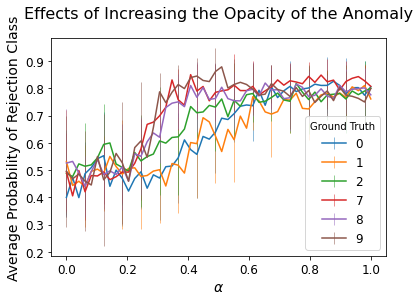

In [0]:
model = rbf_model
alphas = np.linspace(0,1,50)
maxConfidence = np.zeros((6,len(alphas),20))
maxConfidence.fill(-1)
i = 0
classes = [0,1,2,7,8,9]
for alpha in alphas:
    xadv,y_adv,y_label,x_clean = PhysicalAttackLanes(alpha)
    prediction_rejection = model.reject(xadv)
    for j in range(len(classes)):
        idx = np.argmax(y_label,axis=1)==classes[j]
        maxConfidence[j,i,:] = prediction_rejection[idx]
    i += 1
    print('Progress',i,'/',len(alphas))

#plt.rcParams['text.uselatex'] = True
plt.title("Effects of Increasing the Opacity of the Anomaly",fontsize=16,pad=20)
plt.xlabel(r'$\alpha $',fontsize=14)
plt.ylabel("Average Probability of Rejection Class",fontsize=14)
for j in range(len(classes)):
    mu = np.mean(maxConfidence[j],axis=1)
    std = np.std(maxConfidence[j],axis=1)
    plt.errorbar(alphas,mu,label=str(classes[j]),yerr=std,elinewidth=0.5,errorevery=3)

plt.tick_params(axis='both',labelsize=12)
plt.legend(title='Ground Truth',loc='lower right',prop={'size': 12})
plt.savefig('/content/Effects_Of_Modifying_Alpha.eps', format='eps', dpi=1000,bbox_inches='tight')
plt.show()

## Define show the shift in confidence on the attack images

Number of test data 908
Creating physical attacks against e2e dave ii model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DAVE-II RBF Probability of Rejection Class
Clean data less than 0.05 : 0.0
Dirty data less than 0.05 : 0.0




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


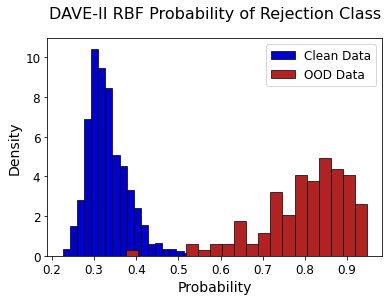

In [0]:
x_test,y_test = test_data_generator.next()
print('Number of test data',y_test.shape[0])
xadv,yadv,y_true,x_clean = PhysicalAttackLanes()
P1 = rbf_model.reject(x_test)
Y1=y_test
P2=rbf_model.reject(xadv)
Y2=yadv
title = 'DAVE-II RBF Probability of Rejection Class'
showMax=False
showRejection = True
numGraphs = 2
thresh = 0.05
plt.figure()
if showRejection:
    confidence = P1
elif showMax:
    confidence = P1[np.arange(P1.shape[0]),np.argmax(P1,axis=1)]
else:
    confidence = P1[np.arange(P1.shape[0]),np.argmax(Y1,axis=1)]

perc = np.percentile(confidence,90)
#print('95th Percentile: ', perc)
print(title)
print('Clean data less than', str(thresh),': ',end='')
print(np.sum(confidence<thresh)/len(confidence))
#print(np.sum(np.bitwise_and(confidence<0.5,np.argmax(P1,axis=1) == np.argmax(Y1,axis=1))))
plt.hist(confidence,bins=20,density=1,label='Clean Data',color='mediumblue', edgecolor='black', linewidth=0.7)
if numGraphs==2:
    if showRejection:
        confidence = P2
    elif showMax:
        confidence = P2[np.arange(P2.shape[0]),np.argmax(P2,axis=1)]
    else:
        confidence = P2[np.arange(P2.shape[0]),np.argmax(Y2,axis=1)]
    if (showMax or showRejection): # daveii analysis
        label = 'OOD Data'
    else:
        label = 'Backdoor Data'
    plt.hist(confidence,bins=20,density=1,label=label,color='firebrick', edgecolor='black', linewidth=0.7)
    perc = np.percentile(confidence,90)
    #print('95th Percentile: ', perc)
    print('Dirty data less than', str(thresh),': ',end='')
    print(np.sum(confidence<thresh)/len(confidence))
    print('\n')
    plt.title(title,fontsize=16,pad=20)
    plt.tick_params(axis='both',labelsize=12)
    plt.legend(loc='best',prop={'size': 12})
    plt.xlabel('Probability',fontsize=14)
    plt.ylabel('Density',fontsize=14)
    plt.savefig('/content/DaveII_RBF_Test_Confidence.eps', format='eps', dpi=1000,bbox_inches='tight')
    title = title.replace(' ','_')
    plt.show()
    #plt.savefig(os.path.join('./images',title))
    #plt.savefig(os.path.join('./AdversarialDefense/src/images',title))

# DAVEII Regression
The following is utility function to load the regression data set into a numpy array that can be used by keras, tensorflow, or pytorch with custom data loaders

## A Function to read in a DAVEII Data set

In [0]:
#DataSetLoader.py
#Authored: Matthew Burruss
#Last Edited: 3/28/2019
#Description: Provides functions for loading inputs and outputs from datasets contained in csv files
import numpy as np
import random
import csv

def load_input(pathToFile):
    # initialize loop variables
    inputs = []
    Y = []
    if not os.path.isfile(pathToFile):
        print("File not found.")
        return
    # read images in ProcessData.csv and append to input
    print('Reading inputs...')
    with open(pathToFile, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        list = []
        rownum = 1
        img_num = -1
        images_processed = 0
        for row in reader:
            if (images_processed == img_num):
                break
            if (rownum == 1):
                img_num = int(row[0])
                rownum = rownum + 1
                continue
            else:
                list.append(row)
            # every other row: get the images (each image is spread 13200x3 in excel)
            if ((rownum-1) %3 == 0):
                img = np.asarray(list,dtype=np.uint8)
                img = np.resize(img,(66,200,3))
                inputs.append(img)
                list = []
                images_processed = images_processed + 1
            rownum = rownum + 1
    return np.array(inputs)

def load_output(pathToFile):
    # initialize loop variables
    Steering=[]
    Acceleration=[]
    if not os.path.isfile(pathToFile):
        print("File not found.")
        return
    # read images in ProcessData.csv and append to input
    print('Reading outputs...')
    with open(pathToFile, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        rownum = 1
        for row in reader:
            if (rownum == 1):
                img_num = int(row[0])
                rownum = rownum + 1
                continue
            # steering duty cycles
            if (rownum == img_num*3+4):
                for steering in row:
                    output = []
                    y=(float(steering)-10.0)/(20.0-10.0)
                    output.append(y)
                    Steering.append(output)
            # acc duty cycles
            elif (rownum == img_num*3+3):
                for acc in row:
                    output = []
                    acc=(float(acc)-10.0)/(20.0-10.0)
                    output.append(acc)
                    Acceleration.append(output)
            rownum = rownum + 1
    steer = np.array(Steering)
    acc = np.array(Acceleration)
    return np.concatenate((steer,acc),axis=1)


X = load_input(PATH_TO_REGRESSION_CSV)
Y = load_output(PATH_TO_REGRESSION_CSV)
# normalize X
X = X/255.

print('X shape: ',X.shape)
print('Y.shape: ',Y.shape)

Reading inputs...
X shape:  (3000, 66, 200, 3)


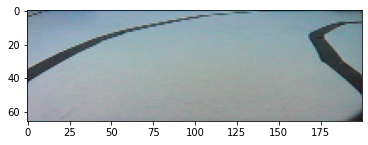

In [0]:
plt.imshow(X[0])
plt.show()